In [1]:
import os,sys,glob,fitsio,subprocess
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import healpy as hp
import astropy.io
from astropy.io import fits
from astropy.table import Table, Column
import desimodel.io
import desimodel.footprint
import matplotlib.style
import matplotlib as mpl
from desitarget import mtl
from desisim.quickcat import quickcat
from desitarget.targetmask import desi_mask, obsconditions
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# **Setting output path for this notebook**

In [2]:
# Change this path if you want
outdir= os.path.join(os.environ['SCRATCH'],'desi/priority_tests/')
os.makedirs(outdir, exist_ok=True)
os.chdir(outdir)
print('Working on {}'.format(outdir))

Working on /global/cscratch1/sd/andsouza/desi/priority_tests/


# **Selecting the Year 1 footprint from a surveysim**

First we read the exposure.fits file from surveysims path

In [3]:
sim_path = "/project/projectdirs/desi/datachallenge/surveysim2018/weather/035/"
exposures = Table.read(os.path.join(sim_path,'exposures.fits'), hdu=1)
exposures[:5]

MJD,EXPTIME,TILEID,SNR2FRAC,AIRMASS,SEEING,TRANSP,SKY
float64,float32,int32,float32,float32,float32,float32,float32
58819.063888888886,920.0,28576,0.5002821,1.0944833,1.01959,0.9735375,1.0
58819.07523148129,660.0,28576,1.00477,1.0944833,0.9895672,0.9818349,1.0
58819.08425925893,1080.0,28589,0.50211537,1.093335,1.1533324,0.96132696,1.0
58819.09745370316,650.0,28589,1.0113196,1.093335,0.87564546,0.9578879,1.0
58819.10636574006,610.0,28588,0.5042863,1.096941,0.77289426,0.9925911,1.0


Find which tiles are covered during the first year

In [4]:
cadence=365
w=np.where(np.int_((exposures['MJD']-exposures['MJD'].min())/cadence)==0)

In [5]:
year1=exposures[w]
year1[:5]

MJD,EXPTIME,TILEID,SNR2FRAC,AIRMASS,SEEING,TRANSP,SKY
float64,float32,int32,float32,float32,float32,float32,float32
58819.063888888886,920.0,28576,0.5002821,1.0944833,1.01959,0.9735375,1.0
58819.07523148129,660.0,28576,1.00477,1.0944833,0.9895672,0.9818349,1.0
58819.08425925893,1080.0,28589,0.50211537,1.093335,1.1533324,0.96132696,1.0
58819.09745370316,650.0,28589,1.0113196,1.093335,0.87564546,0.9578879,1.0
58819.10636574006,610.0,28588,0.5042863,1.096941,0.77289426,0.9925911,1.0


For this test we will use a small area, so first we will get those tiles in a 100 sq.deg

### **Reducing by area**

In [6]:
alltiles = Table(desimodel.io.load_tiles())
dark = alltiles['PROGRAM'] == 'DARK' # We are only DARK targets
tiles= alltiles[dark]

# Change this line if needed, if not needed comment, next twolines
ii = (150 < tiles['RA']) & (tiles['RA']<160) & (20<tiles['DEC']) & (tiles['DEC']<30)
tiles=tiles[ii]

print('There are {} tiles in this area.'.format(len(tiles)))

There are 50 tiles in this area.


## **Tiling plot function**

In [7]:
def plot_sky_circle(x, y, radius, alpha=0.2, color=None):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = x + np.cos(np.radians(y))*radius*np.cos(theta)
    yy = y + radius*np.sin(theta)
    plt.fill(xx, yy, alpha=alpha, color=color)

def plot_tile(ra, dec, color=None, alpha=0.2):
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    plot_sky_circle(ra, dec, tile_radius, color=color)

def plot_tiles(tiles):
    for i in range(len(tiles)):
        plot_tile(tiles['RA'][i], tiles['DEC'][i])
    plt.xlabel('RA [degrees]')
    plt.ylabel('DEC [degrees]')

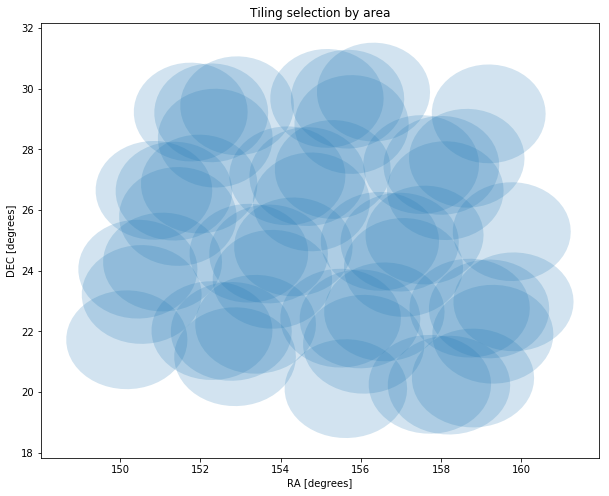

In [8]:
plt.figure(figsize=(10,8))
plt.title('Tiling selection by area')
plot_tiles(tiles)

In [9]:
ii_dark_1 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==1)
ii_dark_2 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==2)
ii_dark_3 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==3)
ii_dark_4 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==4)
layers = [ii_dark_1, ii_dark_2, ii_dark_3, ii_dark_4]

ii_dark_1.sum(), ii_dark_2.sum(), ii_dark_3.sum(), ii_dark_4.sum()

(14, 12, 12, 12)

Now lets see which of those tiles are covered on the first year and save the exposures.fits file for this area.

### **Reducing by Y1 footprint**

> **The exposures shoud be updated, so while there is match to Y1 footprint**

In [10]:
'''

w=np.isin(tiles['TILEID'], year1['TILEID'])
tiles=tiles[w]
print('There are {} tiles in this small area from Y1 footprint.'.format(len(tiles)))

'''

tiles.write(outdir+'/reduced_tiles.fits',overwrite=True)

In [11]:
'''

plt.figure(figsize=(10,8))
plt.title('Tiling selection covered on the DESI Y1')
plot_tiles(tiles)

'''

"\n\nplt.figure(figsize=(10,8))\nplt.title('Tiling selection covered on the DESI Y1')\nplot_tiles(tiles)\n\n"

In [12]:
expfolder=os.path.join(outdir, 'exposures')
os.makedirs(expfolder,exist_ok=True)
expfile=os.path.join(expfolder, 'exposuresY1.fits')
if os.path.exists(expfile):
    print('exposures file already done; skipping')
    year1=Table(fitsio.read(expfile))
else:
    print('Writing exposure file in {}'.format(expfile))
    w=np.isin(year1['TILEID'], tiles['TILEID'])
    year1=year1[w]
    year1.write(expfile)

Writing exposure file in /global/cscratch1/sd/andsouza/desi/priority_tests/exposures/exposuresY1.fits


In [13]:
!ls

exposures  reduced_tiles.fits


## **Layers**
> Layer is a set of tiles that cover the whole footprint, and there should be 4 dark-time layers and 1 gray-time layers

In [14]:
ii_dark_1 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==1)
ii_dark_2 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==2)
ii_dark_3 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==3)
ii_dark_4 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==4)
layers = [ii_dark_1, ii_dark_2, ii_dark_3, ii_dark_4]

ii_dark_1.sum(), ii_dark_2.sum(), ii_dark_3.sum(), ii_dark_4.sum()

(14, 12, 12, 12)

In [15]:
def plot_layers(tiles, layers):
    
    for i in np.arange(4):
        
        # plt.figure(figsize=(5,5))
        
        ii = layers[i]
        tiles_layer = tiles[ii]
        colors = ['k', 'r', 'g', 'b', 'y', 'm']
                
        for j in range(len(tiles_layer)):
            plot_tile(tiles_layer['RA'][j], tiles_layer['DEC'][j], color=colors[i])
            
        plt.xlabel('RA [degrees]')
        plt.ylabel('DEC [degrees]')
        
        # plt.title('Layer ' + str(i+1))
            
    return

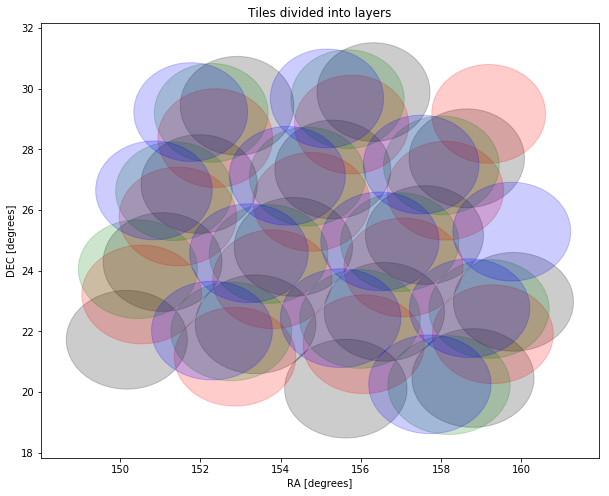

In [16]:
plt.figure(figsize=(10,8))
plt.title('Tiles divided into layers')
plot_layers(tiles, layers)

# **Reducing a whole footprint mock target selection run to match our footprint**

In this step we will select the targets that match the Y1 footprint from a whole footprint mock target selection catalog.

> All targets

```
/project/projectdirs/desi/users/alxogm/desi/select_mock_targets/dark_all_sky_nospec/
```

> Only QSOs

```
/project/projectdirs/desi/users/alxogm/desi/select_mock_targets/onlyqso_all_sky_nospec
```

this is a run of `select_mock_targets` run of only qsos and stars.

In [17]:
def reducefile(file, tiles, outdir='./', nside=16):
    
    tilepixels=desimodel.footprint.tiles2pix(nside=nside, tiles=tiles)
    print('Getting {} footprint pixels from {}'.format(tilepixels.size, file))
    pixels=Table(fitsio.read(file, columns=['HPXPIXEL']))
    whichtargets=np.isin(pixels['HPXPIXEL'], tilepixels)
    rows=np.where(whichtargets==True)[0]
    
    filename=os.path.split(file)[-1]
    print('Reducing data')
    reduced = Table(fitsio.read(file,rows=rows))
    name=os.path.join(outdir, filename)
    print(f'Writing reduced file {name}')
    reduced.write(name, overwrite=True)
    print('DONE')
    del reduced
    
    return rows

In [18]:
def make_reducefile(filelist, nside=16):

    do_reducefiles = False
    do_mtl=False

    if not os.path.exists(mtlfile):
        do_mtl=True

    for filename in filelist:
        if not os.path.exists(os.path.join(outdir, filename)):
            do_reducefiles = True
            break

    if not do_reducefiles:
        print('Already reduced files; skipping')
    else:
        print('Reducing files.')
        sky = reducefile(skyfile, tiles, outdir, nside=nside)

        if not do_mtl:
            rows = reducefile(mtlfile, tiles, outdir, nside=nside)
        else:
            print('MTL file does not exist in input path, generating reduced mtl for this run')
            rows = reducefile(targetfile, tiles, outdir, nside=nside)
            targets=fitsio.read(os.path.join(outdir,'targets-dark.fits'))
            mtl = mtl.make_mtl(targets, obscon='DARK')
            mtlname=os.path.join(outdir,'mtl-dark.fits')
            mtl.meta['EXTNAME'] = 'MTL'
            mtl.write(mtlname, overwrite=True, format='fits')

        print('Reducing truth file')   
        reduced_truth = Table(fitsio.read(truthfile, rows=rows)) 
        # Truth file doesn't contain a HPXPIXEL column but its aranged the same way as mtl
        reduced_truth.write(os.path.join(outdir,'truth-dark.fits'), overwrite=True)
        #del reduced_truth
        print('DONE')
        
        return

In [19]:
mockpath='/global/cfs/projectdirs/desi/mocks/lya_forest/develop/london/smt/nospectra/onlyqso_all_sky_nospec/' 
# Only QSO catalog
truthfile=os.path.join(mockpath,'truth-dark.fits')
mtlfile=os.path.join(mockpath,'mtl-dark.fits')
targetfile=os.path.join(mockpath,'targets-dark.fits')
skyfile=os.path.join(mockpath,'sky.fits')
fbadir=os.path.join(mockpath,'out_fba')

In [20]:
filelist = ['truth-dark.fits', 'mtl-dark.fits', 'sky.fits']
make_reducefile(filelist, nside=16)

Reducing files.
Getting 19 footprint pixels from /global/cfs/projectdirs/desi/mocks/lya_forest/develop/london/smt/nospectra/onlyqso_all_sky_nospec/sky.fits
Reducing data
Writing reduced file /global/cscratch1/sd/andsouza/desi/priority_tests/sky.fits
DONE
Getting 19 footprint pixels from /global/cfs/projectdirs/desi/mocks/lya_forest/develop/london/smt/nospectra/onlyqso_all_sky_nospec/mtl-dark.fits
Reducing data
Writing reduced file /global/cscratch1/sd/andsouza/desi/priority_tests/mtl-dark.fits
DONE
Reducing truth file
DONE


* **The reduce file functions does not work for nside != 16**
> It would be useful to work with maps with higer resolution later

In [21]:
!ls

exposures  mtl-dark.fits  reduced_tiles.fits  sky.fits	truth-dark.fits


### **QSOs vs stars**

In [22]:
targets = Table.read('mtl-dark.fits')

In [23]:
ii = targets['DESI_TARGET'] == 4
QSOs = targets[ii]

ii = targets['DESI_TARGET'] != 4
stars = targets[ii]

In [24]:
ratio_qso = 100*len(QSOs)/len(targets)
ratio_stars = 100*len(stars)/len(targets)
print("Ratio of QSOs in the MTL: %.1f%%" % ratio_qso)
print("Ratio of stars in the MTL: %.1f%%" % ratio_stars)

Ratio of QSOs in the MTL: 14.0%
Ratio of stars in the MTL: 86.0%


# **Running the fiber assignment code to  only QSOs and stars**

In [25]:
truth_reduced=os.path.join(outdir,'truth-dark.fits')
mtl_reduced=os.path.join(outdir,'mtl-dark.fits')
sky_reduced=os.path.join(outdir,'sky.fits')
tiles_reduced=os.path.join(outdir,'reduced_tiles.fits')
fbadir=os.path.join(outdir,'fba')

* By default, fiberassign uses the real focalplane geometry and properties at the current time. During operations, if a fiber broke yesterday and you run fiberassign today with an up-to-date desimodel data checkout, then that fiber will not be assigned. For this tutorial, we will run fiberassign with a rundate set to a time in the past before the start of commissioning. This will give us a nominal focalplane layout with all positioners working.

In [26]:
assign_date= "2020-01-01T00:00:00"

In [27]:
# Run fiberassign
cmd = 'fiberassign --overwrite --mtl {mtl} --sky {sky}'
cmd += ' --rundate {}'.format(assign_date)
cmd += ' --footprint {tiles}'
cmd += ' --outdir {out}'
cmd = cmd.format(mtl=mtl_reduced, sky=sky_reduced, tiles=tiles_reduced, out=fbadir)

In [28]:
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())
    raise ex

RUNNING: fiberassign --overwrite --mtl /global/cscratch1/sd/andsouza/desi/priority_tests/mtl-dark.fits --sky /global/cscratch1/sd/andsouza/desi/priority_tests/sky.fits --rundate 2020-01-01T00:00:00 --footprint /global/cscratch1/sd/andsouza/desi/priority_tests/reduced_tiles.fits --outdir /global/cscratch1/sd/andsouza/desi/priority_tests/fba
INFO: Loaded focalplane for time stamp 2020-01-01 00:00:00
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Target file /global/cscratch1/sd/andsouza/desi/priority_tests/mtl-dark.fits has 281327 rows.  Reading in chunks of 1000000
INFO: Read target file /global/cscratch1/sd/andsouza/desi/priority_tests/mtl-dark.fits:  0.69 seconds (1 calls)
INFO: Target file /global/cscratch1/sd/andsouza/desi/priority_tests/sky.fits has 311296 rows.  Reading in chunks of 1000000
INFO: Read target file /global/cscratch1/sd/andsouza/desi/priority_tests/sky.fits:  0.74 seconds (1 calls)
INFO: Building target tree:  0.21 seconds (1 calls)
INFO: Computing targe

In [29]:
!ls fba

fba-011053.fits  fba-022670.fits	  fiberassign-016837.fits
fba-011072.fits  fba-022671.fits	  fiberassign-016854.fits
fba-011073.fits  fba-022687.fits	  fiberassign-016855.fits
fba-011074.fits  fba-022688.fits	  fiberassign-016856.fits
fba-011075.fits  fba-028358.fits	  fiberassign-016907.fits
fba-011092.fits  fba-028359.fits	  fiberassign-016908.fits
fba-011093.fits  fba-028360.fits	  fiberassign-016909.fits
fba-011094.fits  fba-028361.fits	  fiberassign-016926.fits
fba-011095.fits  fba-028378.fits	  fiberassign-022596.fits
fba-011145.fits  fba-028379.fits	  fiberassign-022597.fits
fba-011146.fits  fba-028431.fits	  fiberassign-022598.fits
fba-011147.fits  fba-028432.fits	  fiberassign-022599.fits
fba-011163.fits  fba-028433.fits	  fiberassign-022616.fits
fba-011164.fits  fba-028449.fits	  fiberassign-022617.fits
fba-011660.fits  fba-028450.fits	  fiberassign-022618.fits
fba-016834.fits  fba-028451.fits	  fiberassign-022669.fits
fba-016835.fits  fiberassign-011053.fits  fiberassign-02

## **Fiber assignment distribution to targets**

* How many were targets covered by fibers
* How many were targets really assigned to one?

In [30]:
def get_assigned_covered(targets, tiles, outdir):
    assigned_ids = list()
    covered_ids = list()
    for tileid in tiles['TILEID']:
        fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tileid)
        assignments = Table.read(fafile, 'FIBERASSIGN')
        assigned_ids.extend(assignments['TARGETID'])

        #- Note: a single target could be covered by more than one fiber on the same tile, 
        # but it still can only be assigned once, so use np.unique() per tile
        # to not double count those cases
        potential = Table.read(fafile, 'POTENTIAL_ASSIGNMENTS')
        # a table of what targets were covered by what fibers
        covered_ids.extend(np.unique(potential['TARGETID']))

    #- Trim to just science targets (i.e. not SKY, not non-science STDSTAR)
    assigned_ids = np.array(assigned_ids)
    ii = np.in1d(assigned_ids, targets['TARGETID'])
    assigned_ids = assigned_ids[ii]

    covered_ids = np.array(covered_ids)
    ii = np.in1d(covered_ids, targets['TARGETID'])
    covered_ids = covered_ids[ii]

    return assigned_ids, covered_ids

In [31]:
#- Do a bit of counting magic to include targets that were never assigned or covered
def count_coverage(targets, ids):
    c = Counter(ids)
    c.update(targets['TARGETID'])
    count = np.array(list(c.values())) - 1
    return count

In [32]:
def plot_counting_assign(targets, tiles, outdir):
    
    assigned_ids, covered_ids = get_assigned_covered(targets, tiles, outdir)
    assigned_count = count_coverage(targets, assigned_ids)
    covered_count = count_coverage(targets, covered_ids)
    
    plt.figure(figsize=(6,8))

    plt.subplot(211)
    plt.hist(assigned_count, 5, (-0.5, 4.5), rwidth=0.8)
    plt.xticks(np.arange(0,5))
    plt.xlabel('number of times assigned')

    plt.subplot(212)
    plt.hist(covered_count, 5, (-0.5, 4.5), rwidth=0.8)
    plt.xticks(np.arange(0,5))
    plt.xlabel('number of times covered')

    plt.tight_layout()
    
    return

In [33]:
def plot_fiber_assign(targets, tiles, outdir):
    
    assignments = list()
    for tileid in tiles['TILEID']:
        fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tileid)
        assignments.append(Table.read(fafile, hdu=1))

    assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
    isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)
    
    plt.subplot(131)
    plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
    plt.title('Targets assigned to fibers')
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    
    potential_targets = list()
    for tileid in tiles['TILEID']:
        fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tileid)
        potential_targets.append(Table.read(fafile, hdu=4))

    potential_targetids = np.concatenate([tmp['TARGETID'] for tmp in potential_targets])
    potential_targetids = np.unique(potential_targetids)  

    ii = np.in1d(potential_targetids, assigned_targetids, invert=True)
    potential_unassigned = potential_targetids[ii]

    notAssigned = np.in1d(targets['TARGETID'], potential_unassigned)

    plt.subplot(132)
    plt.plot(targets['RA'][notAssigned], targets['DEC'][notAssigned], 'k,')
    plt.title('Potential targets not assigned to fibers')
    plt.xlabel('RA [deg]')
    # plt.ylabel('DEC [deg]')
    
    notPotential = np.in1d(targets['TARGETID'], np.concatenate([assigned_targetids, potential_unassigned]), 
                       invert=True)

    plt.subplot(133)
    plt.plot(targets['RA'][notPotential], targets['DEC'][notPotential], 'k,')
    plt.title('Unavailable targets')
    plt.xlabel('RA [deg]')
    # plt.ylabel('DEC [deg]')  
    
    n_isAssigned = np.count_nonzero(isAssigned)
    n_notAssigned = np.count_nonzero(notAssigned)
    n_notPotential = np.count_nonzero(notPotential)
    
    n_targets = len(targets['TARGETID'])
    n_fibers = int(0.9 * len(tiles) * 5000)  
    # 10% of fibers are reserved for std and sky calibrators

    
    assert n_isAssigned + n_notAssigned + n_notPotential == n_targets
    
    print('Total of targets:                 ', n_targets)
    print('Targets assigned:                 ', n_isAssigned)
    print('Estimation of counting fibers:    ', n_fibers)
    print('Potential targets not assigned:   ', n_notAssigned)
    print('Unavailable targets:              ', n_notPotential)
    print()
    
    print('Percentage over the total number of targets')
    print('Targets assigned:                 %.2f%%' % (100*n_isAssigned/n_targets))
    print('Potential targets not assigned:   %.2f%%' % (100*n_notAssigned/n_targets))
    print('Unavailable targets:              %.2f%%' % (100*n_notPotential/n_targets))
    print()
    
    print('Targets assigned/Counting fibers: %.2f%%' % (100*n_isAssigned/n_fibers))
    
    return 

In [34]:
def cross_assign_cover(targets, tiles, outdir):

    assigned_ids, covered_ids = get_assigned_covered(targets, tiles, outdir)

    count_assigned = Counter(assigned_ids)
    count_covered = Counter(covered_ids)    
    
    n_max, m_max = 0, 0
    
    for tid in targets['TARGETID']:
        n = count_assigned[tid]
        m = count_covered[tid]
        if n > n_max: n_max = n
        if m > m_max: m_max = m
            
    n2d = np.ones((n_max+1, m_max+1), dtype=int)
    
    for tid in targets['TARGETID']:
        n = count_assigned[tid]
        m = count_covered[tid]
        n2d[n,m] += 1    
            
    import seaborn as sns
    from matplotlib.colors import LogNorm
    
    log_norm = LogNorm(vmin=n2d.min().min(), vmax=n2d.max().max())
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(n2d.min().min())), 1+math.ceil(math.log10(n2d.max().max())))]

    ax = sns.heatmap(n2d, cmap="YlGnBu", norm=log_norm, cbar_kws={"ticks": cbar_ticks})
    plt.xlabel('Number of times Covered')
    plt.ylabel('Number of times Assigned')

## **Getting only QSOs**

In [35]:
targets = Table.read(mtl_reduced)
ii = targets['DESI_TARGET'] == 4
targets = targets[ii]

tiles = Table.read(tiles_reduced)
fbadir=os.path.join(outdir,'fba')

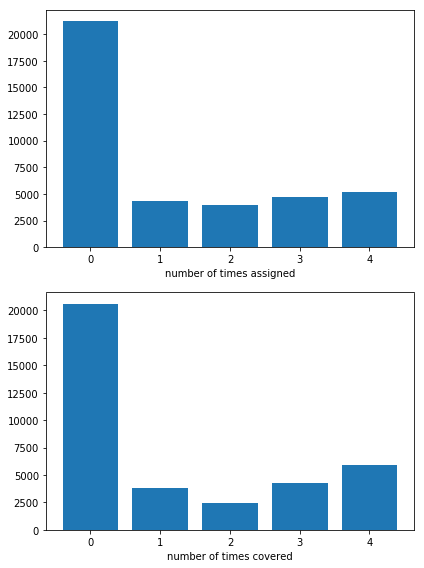

In [36]:
plot_counting_assign(targets, tiles, fbadir)

Total of targets:                  39355
Targets assigned:                  18147
Estimation of counting fibers:     225000
Potential targets not assigned:    601
Unavailable targets:               20607

Percentage over the total number of targets
Targets assigned:                 46.11%
Potential targets not assigned:   1.53%
Unavailable targets:              52.36%

Targets assigned/Counting fibers: 8.07%


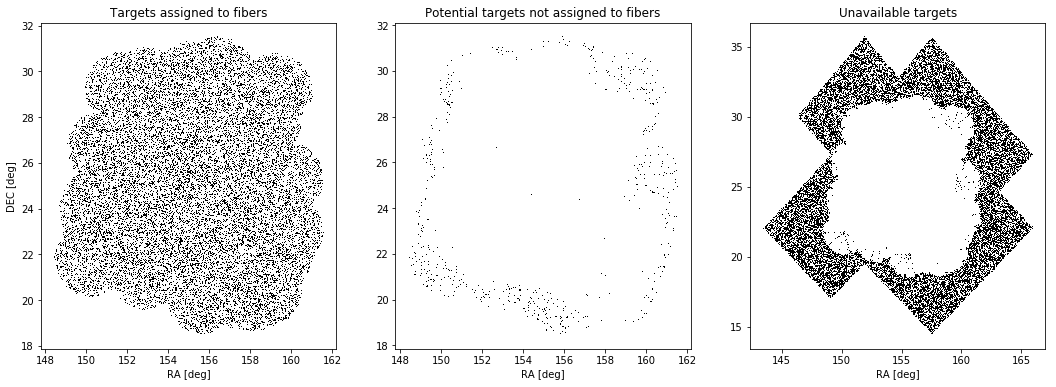

In [37]:
plt.figure(figsize=(18,6))
plot_fiber_assign(targets, tiles, fbadir)

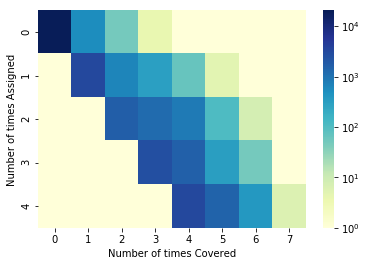

In [38]:
cross_assign_cover(targets, tiles, fbadir)

# **Create a first zcatalog as it is done in multipass**

* The git repo of the multipass code is on this [link](https://github.com/forero/multipass/blob/42c9d13c5ceb9a61c362e2f8117acb697fc29735/run_multilayer.py#L342-L346).
* The function that create the redshift catalog is the [desisim/quickcat.py](https://github.com/desihub/desisim/blob/fddf9c808400918edd55fec9a17b12e066293295/py/desisim/quickcat.py#L563).

Code for quickly generating an output zcatalog given fiber assignment tiles, a truth catalog, and optionally a previous zcatalog.

> **quickcat(tilefiles, targets, truth, zcat=None, obsconditions=None, perfect=False)**

    Generates quick output zcatalog
    Args:
        tilefiles : list of fiberassign tile files that were observed
        targets : astropy Table of targets
        truth : astropy Table of input truth with columns TARGETID, TRUEZ, and TRUETYPE
        zcat (optional): input zcatalog Table from previous observations
        obsconditions (optional): Table or ndarray with observing conditions from surveysim
        perfect (optional): if True, treat spectro pipeline as perfect with input=output,
            otherwise add noise and zwarn!=0 flags
    Returns:
        zcatalog astropy Table based upon input truth, plus ZERR, ZWARN,
        NUMOBS, and TYPE columns

* All the FiberAssign outputs

In [39]:
fba_files = np.sort(glob.glob(os.path.join(fbadir,"fiberassign*.fits")))

In [40]:
zcat = quickcat(fba_files, Table.read(mtl_reduced), Table.read(truth_reduced), perfect=True)

INFO:quickcat.py:585:quickcat: Mon Apr 27 13:59:24 2020 QC Reading 50 tiles
INFO:quickcat.py:629:quickcat: Mon Apr 27 13:59:28 2020 QC Trimming truth to just observed targets
INFO:quickcat.py:636:quickcat: Mon Apr 27 13:59:28 2020 QC Constructing new redshift catalog
INFO:quickcat.py:648:quickcat: Mon Apr 27 13:59:28 2020 QC Adding ZERR and ZWARN
INFO:quickcat.py:666:quickcat: Mon Apr 27 13:59:28 2020 QC Adding NUMOBS column
INFO:quickcat.py:672:quickcat: Mon Apr 27 13:59:29 2020 QC Merging previous zcat
INFO:quickcat.py:719:quickcat: Mon Apr 27 13:59:29 2020 QC done


In [41]:
zcat[:5]

TARGETID,BRICKNAME,SPECTYPE,Z,ZERR,ZWARN,NUMOBS
int64,str8,str10,float32,float32,int32,int32
288230383395275605,,QSO,2.313405,0.0,0,1
288230383395275606,,QSO,2.5355,0.0,0,1
288230383395275610,,QSO,2.1095347,0.0,0,1
288230383395275617,,QSO,2.3436482,0.0,0,1
288230383395275688,,QSO,2.4378078,0.0,0,1


### **Generating some targets with warning redshift**
> Only to simulate (there is no realistic prediction yet): 10% of the sample

In [42]:
import random
ii = random.sample(range(0, len(zcat)), int(0.1*len(zcat)))
zcat['ZWARN'][ii] = 1

In [43]:
zcatfile = os.path.join(outdir, 'zcat.fits')

In [44]:
zcat.write(zcatfile, overwrite=True)

# **Quasar re-observation**

> Getting an external input to update the information regarding priorities before each call to fiber assignment
* modify priority set between calls of fiber assignment based for example on the agreement to redshift fitters

In [45]:
from desitarget import mtl

## **The mtl.make_mtl function**
* Look at this function at [desitarget/mtl.py](https://github.com/desihub/desitarget/blob/c56191a86625e09a2237c641351ac9b7c663b185/py/desitarget/mtl.py#L19)
* It adds NUMOBS_MORE, PRIORITY, and OBSCONDITIONS columns to a targets table
* Inputs: make_mtl(targets, obscon, zcat=None, trim=False, scnd=None)

> Before this moment, the `PRIORITY` is used only to separate science targets from sky and standard stars in the mtl file, giving to the first ones more priority during the fiber assignment.

> **def make_mtl(targets, obscon, zcat=None, trim=False, scnd=None)**:
    
    Adds NUMOBS_MORE, PRIORITY, and OBSCONDITIONS columns to a targets table.
    Parameters
    ----------
    targets : :class:`~numpy.array` or `~astropy.table.Table`
        A numpy rec array or astropy Table with at least the columns
        ``TARGETID``, ``DESI_TARGET``, ``NUMOBS_INIT``, ``PRIORITY_INIT``.
        or the corresponding columns for SV or commissioning.
    zcat : :class:`~astropy.table.Table`, optional
        Redshift catalog table with columns ``TARGETID``, ``NUMOBS``, ``Z``,
        ``ZWARN``.
    Returns
    -------
    :class:`~astropy.table.Table`
        MTL Table with targets columns plus:
        * NUMOBS_MORE    - number of additional observations requested
        * PRIORITY       - target priority (larger number = higher priority)

In [46]:
mtl_reobs = mtl.make_mtl(Table.read(mtl_reduced), 'DARK', zcat=zcat)

INFO:mtl.py:161:make_mtl: 99545 of 281327 targets have priority zero, setting N_obs=0.
INFO:mtl.py:197:make_mtl: Done...t=0.5s


## **Check the make_mtl output**

In [47]:
import pandas as pd
reobs_pd = pd.DataFrame()
reobs_pd['TARGETID'] = mtl_reobs['TARGETID']
reobs_pd['DESI_TARGET'] = mtl_reobs['DESI_TARGET']
reobs_pd['NUMOBS'] = np.zeros(len(mtl_reobs))
reobs_pd['PRIORITY_INIT'] = mtl_reobs['PRIORITY_INIT']
reobs_pd['Z'] = -np.ones(len(mtl_reobs))
reobs_pd['ZWARN'] = np.zeros(len(mtl_reobs))
reobs_pd['NUMOBS_MORE'] = mtl_reobs['NUMOBS_MORE']
reobs_pd['PRIORITY'] = mtl_reobs['PRIORITY']

### **Adding info about targets observed at the first running**

In [48]:
w = isin(reobs_pd['TARGETID'], zcat['TARGETID'])
reobs_pd['Z'][w] = zcat['Z']
reobs_pd['ZWARN'][w] = zcat['ZWARN']
reobs_pd['NUMOBS'][w] = zcat['NUMOBS']

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

Text(0.5,0,'Redshift z')

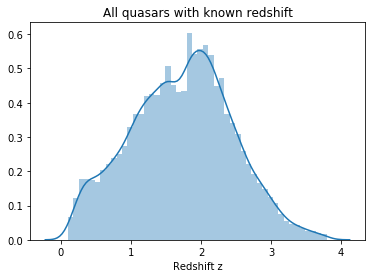

In [49]:
ii = (reobs_pd['DESI_TARGET'] == 4) & (reobs_pd['Z'] != -1)
sns.distplot(reobs_pd['Z'][ii], kde=True)
plt.title('All quasars with known redshift')
plt.xlabel('Redshift z')

In [50]:
desi_mask['QSO'].priorities

{'UNOBS': 3400,
 'MORE_ZGOOD': 3500,
 'DONE': 2,
 'OBS': 1,
 'DONOTOBSERVE': 0,
 'MORE_ZWARN': 3400}

In [51]:
ii = reobs_pd['DESI_TARGET'] == 4
reobs_pd[ii].groupby(['PRIORITY', 'ZWARN', 'NUMOBS', 'NUMOBS_MORE'])['Z'].describe()

count      mean       std       min  \
PRIORITY ZWARN NUMOBS NUMOBS_MORE                                          
2        0.0   1.0    0             2797.0  1.380353  0.526739  0.104501   
               2.0    0             2558.0  1.387988  0.522023  0.104901   
               3.0    0             3006.0  1.368450  0.535923  0.101982   
               4.0    0             4699.0  1.722161  0.729446  0.103528   
         1.0   4.0    0              520.0  1.750951  0.738873  0.139247   
3400     0.0   0.0    4            21208.0 -1.000000  0.000000 -1.000000   
         1.0   1.0    3              414.0  1.758845  0.719978  0.141378   
               2.0    2              367.0  1.628338  0.718442  0.125012   
               3.0    1              471.0  1.718545  0.721320  0.202105   
3500     0.0   1.0    3             1106.0  2.580082  0.341373  2.150004   
               2.0    2             1013.0  2.578192  0.340176  2.152517   
               3.0    1             1196.0  2.582389  0.352897  2.150060   

                                        25%       50%       75%       max  
PRIORITY ZWARN NUMOBS NUMOBS_MORE                                          
2        0.0   1.0    0            1.022274  1.453473  1.832517  2.149708  
               2.0    0            1.023617  1.450259  1.836971  2.149791  
               3.0    0            0.995356  1.435473  1.835437  2.149557  
               4.0    0            1.204708  1.769262  2.216434  3.797181  
         1.0   4.0    0            1.283646  1.818863  2.241265  3.746423  
3400     0.0   0.0    4           -1.000000 -1.000000 -1.000000 -1.000000  
         1.0   1.0    3            1.258306  1.800168  2.262568  3.602204  
               2.0    2            1.122218  1.596034  2.104177  3.790972  
               3.0    1            1.195176  1.721076  2.228166  3.759663  
3500     0.0   1.0    3            2.291276  2.515519  2.791568  3.780120  
               2.0    2            2.314305  2.496373  2.759489  3.795638  
               3.0    1            2.302032  2.479996  2.799990  3.793410

Text(0.5,0,'Redshift z')

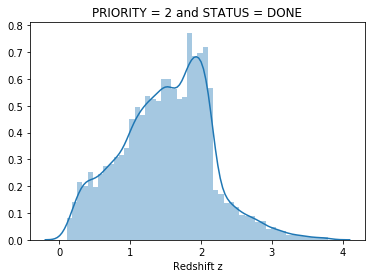

In [52]:
ii = (reobs_pd['DESI_TARGET'] == 4) & (reobs_pd['PRIORITY'] == 2)
sns.distplot(reobs_pd['Z'][ii], kde=True)
plt.title('PRIORITY = 2 and STATUS = DONE')
plt.xlabel('Redshift z')

Text(0.5,0,'Redshift z')

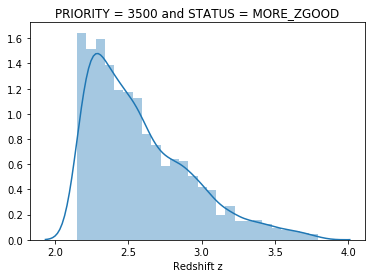

In [53]:
ii = (reobs_pd['DESI_TARGET'] == 4) & (reobs_pd['PRIORITY'] == 3500)
sns.distplot(reobs_pd['Z'][ii])
plt.title('PRIORITY = 3500 and STATUS = MORE_ZGOOD')
plt.xlabel('Redshift z')

## **Re-run the fiber assignment after updated priorities**

In [54]:
mtlfile=os.path.join(outdir,'mtl-reobs.fits')

In [55]:
mtl_reobs.write(mtlfile, overwrite=True)

In [56]:
fbadir = os.path.join(outdir,'fba-reobs')

In [57]:
# Run fiberassign
cmd = 'fiberassign --overwrite --mtl {mtl} --sky {sky}'
cmd += ' --rundate {}'.format(assign_date)
cmd += ' --footprint {tiles}'
cmd += ' --outdir {out}'
cmd = cmd.format(mtl=mtlfile, sky=sky_reduced, tiles=tiles_reduced, out=fbadir)

In [58]:
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())
    raise ex

RUNNING: fiberassign --overwrite --mtl /global/cscratch1/sd/andsouza/desi/priority_tests/mtl-reobs.fits --sky /global/cscratch1/sd/andsouza/desi/priority_tests/sky.fits --rundate 2020-01-01T00:00:00 --footprint /global/cscratch1/sd/andsouza/desi/priority_tests/reduced_tiles.fits --outdir /global/cscratch1/sd/andsouza/desi/priority_tests/fba-reobs
INFO: Loaded focalplane for time stamp 2020-01-01 00:00:00
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Target file /global/cscratch1/sd/andsouza/desi/priority_tests/mtl-reobs.fits has 281327 rows.  Reading in chunks of 1000000
INFO: Read target file /global/cscratch1/sd/andsouza/desi/priority_tests/mtl-reobs.fits:  0.71 seconds (1 calls)
INFO: Target file /global/cscratch1/sd/andsouza/desi/priority_tests/sky.fits has 311296 rows.  Reading in chunks of 1000000
INFO: Read target file /global/cscratch1/sd/andsouza/desi/priority_tests/sky.fits:  0.77 seconds (1 calls)
INFO: Building target tree:  0.20 seconds (1 calls)
INFO: Comput

In [59]:
!ls 

exposures  fba-reobs	  mtl-reobs.fits      sky.fits	       zcat.fits
fba	   mtl-dark.fits  reduced_tiles.fits  truth-dark.fits


### **PRIORITY = 2**

In [60]:
ii = (mtl_reobs['DESI_TARGET'] == 4) & (mtl_reobs['PRIORITY'] == 2)
targets = mtl_reobs[ii]
tiles = Table.read('reduced_tiles.fits')
fbadir = os.path.join(outdir,'fba-reobs')

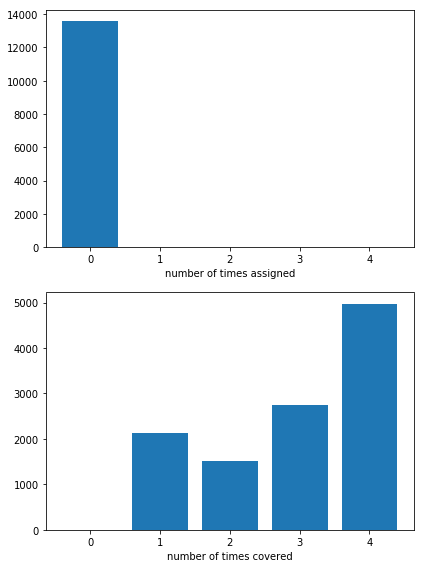

In [61]:
plot_counting_assign(targets, tiles, fbadir)

Total of targets:                  13580
Targets assigned:                  0
Estimation of counting fibers:     225000
Potential targets not assigned:    13580
Unavailable targets:               0

Percentage over the total number of targets
Targets assigned:                 0.00%
Potential targets not assigned:   100.00%
Unavailable targets:              0.00%

Targets assigned/Counting fibers: 0.00%


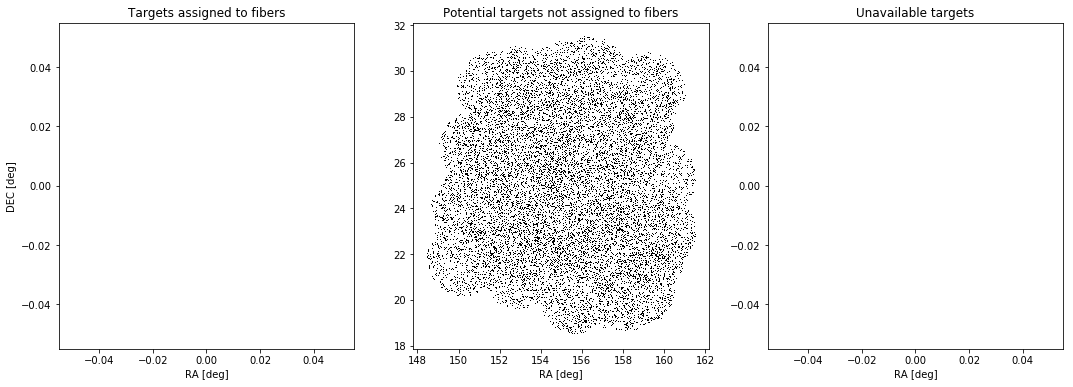

In [62]:
plt.figure(figsize=(18,6))
plot_fiber_assign(targets, tiles, fbadir)

### **PRIORITY = 3400**

In [63]:
ii = (mtl_reobs['DESI_TARGET'] == 4) & (mtl_reobs['PRIORITY'] == 3400)
targets = mtl_reobs[ii]

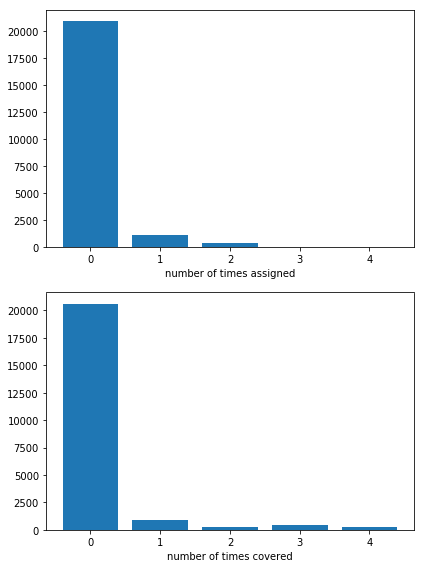

In [64]:
plot_counting_assign(targets, tiles, fbadir)

Total of targets:                  22460
Targets assigned:                  1509
Estimation of counting fibers:     225000
Potential targets not assigned:    344
Unavailable targets:               20607

Percentage over the total number of targets
Targets assigned:                 6.72%
Potential targets not assigned:   1.53%
Unavailable targets:              91.75%

Targets assigned/Counting fibers: 0.67%


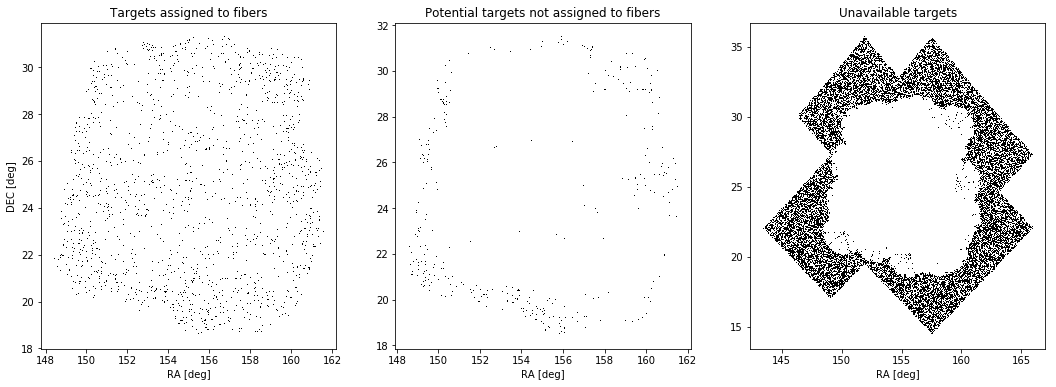

In [65]:
plt.figure(figsize=(18,6))
plot_fiber_assign(targets, tiles, fbadir)

### **PRIORITY = 3500**

In [66]:
ii = (mtl_reobs['DESI_TARGET'] == 4) & (mtl_reobs['PRIORITY'] == 3500)
targets = mtl_reobs[ii]

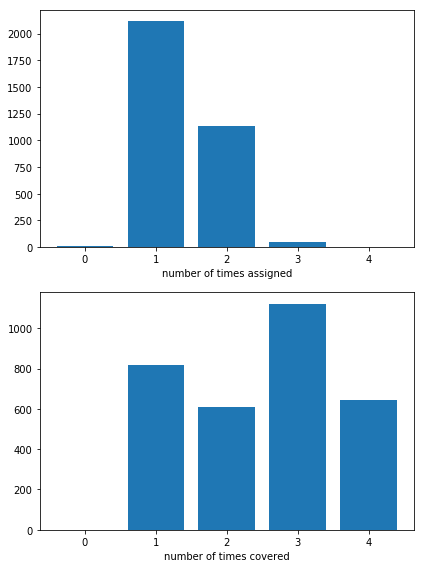

In [67]:
plot_counting_assign(targets, tiles, fbadir)

In [ ]:
plt.figure(figsize=(18,6))
plot_fiber_assign(targets, tiles, fbadir)

## TO DO:

 - Reduce tiling by Y1 surveysims [DONE]
 - Increase nside of maps [FAIL]
 - Increase the area, from 100 to 200 dg² [NEXT]
 - Consider only PROGRAM=DARK [DONE]
 - Rerun all notebook [DONE]
 
 ------------------------------------------------------------------------------------

 - You can add some non-zero warnings before saving the  zcatalog
 - You could also add some random error within a reasonable range
 - Save the zcatalog and use it to update the mtl file and run fiberassign again.  zcat.write('./zcat.fits',overwrite=True)
 - Check that the reobservation occurs as expected. 
 - Continue to try to modify the behaviour of reobservation if we provide information from other classifiers... 
 - Repit using an all target type catalog. 